In [62]:
import torch
import torch.nn as nn
from torch.optim import SGD

import numpy as np
from numpy import dot
import matplotlib.pyplot as plt

In [63]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, num_classes):
        super(NeuralNet, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size1)
        self.hidden_one = nn.Linear(hidden_size1, hidden_size2)
        self.hidden_two = nn.Linear(hidden_size2,hidden_size3)
        self.output_layer = nn.Linear(hidden_size3, num_classes)
    
    def forward(self, x):
        x=self.input_layer(x)
        x=x.relu()
        x=self.hidden_one(x)
        x=x.relu()
        x=self.hidden_two(x)
        x=x.relu()
        x=self.output_layer(x)
        return x
    
def ReLU_glorot_init(model):
    for name, param in model.named_parameters():
        
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            nn.init.xavier_normal_(param)

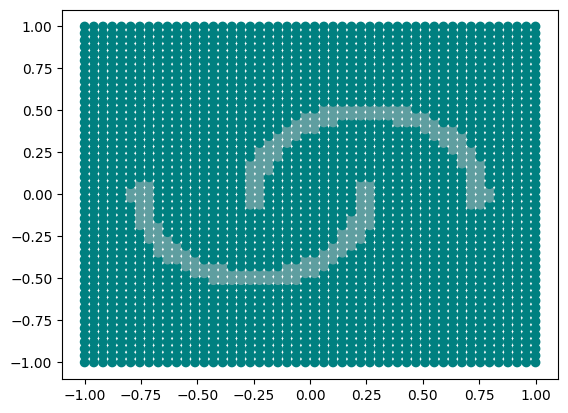

In [64]:
RES=50
X=[]
for x_1 in np.linspace(-1,1,RES):
    for x_2 in np.linspace(-1,1,RES):
        X.append([x_1,x_2])
X=np.array(X)

encode_inputs=lambda x: 1 if (abs((x[0]+0.25)**2+x[1]**2-0.25)<0.05 and x[1]<0.1) or (abs((x[0]-0.25)**2+x[1]**2-0.25)<0.05 and x[1]>-0.1) else 0
Y=np.array([encode_inputs(x) for x in X])

X=torch.from_numpy(X).float()
Y=torch.from_numpy(Y).float()


colors=np.full(len(Y), 'cadetblue')
colors[Y==0]='teal'

plt.scatter(X[:,0],X[:,1],c=colors)

In [65]:
model = NeuralNet(2,16,8,16,2)
ReLU_glorot_init(model)

def next_batch(inputs, targets, batchSize):
	for i in range(0, inputs.shape[0], batchSize):
		yield (inputs[i:i + batchSize], targets[i:i + batchSize])

BATCH_SIZE = 100
EPOCHS = 200
LR = 0.01

opt = SGD(model.parameters(), lr=LR)
lossFunc = nn.CrossEntropyLoss()

In [66]:
grads_input_layer=[]
grads_hidden_one=[]
grads_hidden_two=[]
grads_output_layer=[]

for x,y in zip(X,Y):
    predictions = model(x)
    loss = lossFunc(predictions, y.long())
    opt.zero_grad()
    loss.backward()
    gradient_input_layer=[]
    gradient_hidden_one=[]
    gradient_hidden_two=[]
    gradient_output_layer=[]

    gradient_input_layer+=torch.flatten(model.input_layer.weight.grad).tolist()
    gradient_input_layer+=model.input_layer.bias.grad.tolist()

    gradient_hidden_one+=torch.flatten(model.hidden_one.weight.grad).tolist()
    gradient_hidden_one+=model.hidden_one.bias.grad.tolist()

    gradient_hidden_two+=torch.flatten(model.hidden_two.weight.grad).tolist()
    gradient_hidden_two+=model.hidden_two.bias.grad.tolist()

    gradient_output_layer+=torch.flatten(model.output_layer.weight.grad).tolist()
    gradient_output_layer+=model.output_layer.bias.grad.tolist()

    
    gradient_input_layer=np.array(gradient_input_layer)
    gradient_hidden_one=np.array(gradient_hidden_one)
    gradient_hidden_two=np.array(gradient_hidden_two)
    gradient_output_layer=np.array(gradient_output_layer)

    grads_input_layer.append(gradient_input_layer/np.linalg.norm(gradient_input_layer))
    grads_hidden_one.append(gradient_hidden_one/np.linalg.norm(gradient_hidden_one))
    grads_hidden_two.append(gradient_hidden_two/np.linalg.norm(gradient_hidden_two))
    grads_output_layer.append(gradient_output_layer/np.linalg.norm(gradient_output_layer))

dot_matrix_input_layer=[]
dot_matrix_hidden_one=[]
dot_matrix_hidden_two=[]
dot_matrix_output_layer=[]
for i,x1 in enumerate(X):
    avg_dot_input=0
    avg_dot_h1=0
    avg_dot_h2=0
    avg_dot_output=0
    samples=0
    for j,x2 in enumerate(X):
        if np.linalg.norm(x1-x2)<0.05 and i!=j:        
            avg_dot_input+=np.dot(grads_input_layer[i],grads_input_layer[j])
            avg_dot_h1+=np.dot(grads_hidden_one[i],grads_hidden_one[j])
            avg_dot_h2+=np.dot(grads_hidden_two[i],grads_hidden_two[j])
            avg_dot_output+=np.dot(grads_output_layer[i],grads_output_layer[j])
            samples+=1
    avg_dot_input/=samples
    avg_dot_h1/=samples
    avg_dot_h2/=samples
    avg_dot_output/=samples
    dot_matrix_input_layer.append(avg_dot_input)
    dot_matrix_hidden_one.append(avg_dot_h1)
    dot_matrix_hidden_two.append(avg_dot_h2)
    dot_matrix_output_layer.append(avg_dot_output)

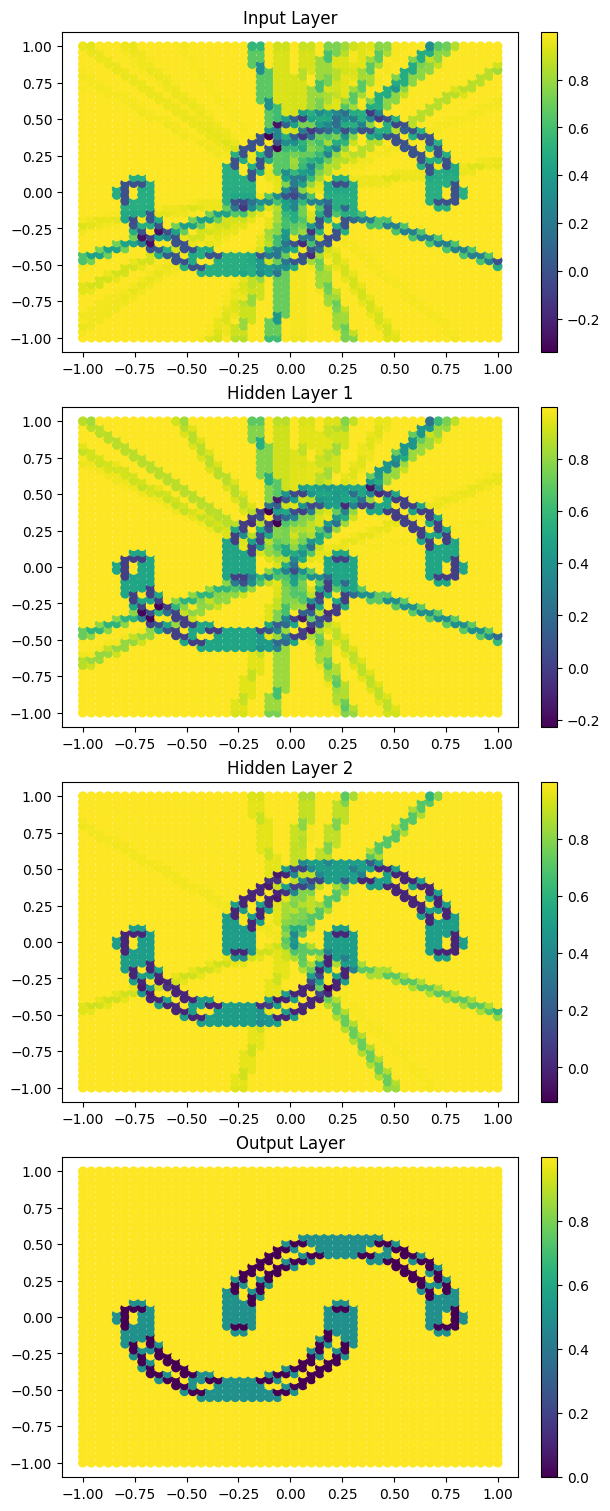

In [67]:
fig, axs = plt.subplots(4,1,figsize=(6,15),layout='constrained')

pcm0 = axs[0].scatter(X[:,0], X[:,1],c=dot_matrix_input_layer)
axs[0].set_title('Input Layer')

fig.colorbar(pcm0, ax=axs[0])

pcm1 = axs[1].scatter(X[:,0], X[:,1],c=dot_matrix_hidden_one)
axs[1].set_title('Hidden Layer 1')

fig.colorbar(pcm1, ax=axs[1])

pcm2 = axs[2].scatter(X[:,0], X[:,1],c=dot_matrix_hidden_two)
axs[2].set_title('Hidden Layer 2')

fig.colorbar(pcm2, ax=axs[2])

pcm3 = axs[3].scatter(X[:,0], X[:,1],c=dot_matrix_output_layer)
axs[3].set_title('Output Layer')

fig.colorbar(pcm3, ax=axs[3])

In [68]:
def training():
	trainLoss = 0
	samples = 0
	model.train()
	for batchX, batchY in next_batch(X, Y, BATCH_SIZE):
		predictions = model(batchX)
		loss = lossFunc(predictions, batchY.long())
		opt.zero_grad()
		loss.backward()
		opt.step()
		samples += len(batchY)
		trainLoss += loss.item()*len(batchY)
	return trainLoss/samples

In [69]:
for n in range(EPOCHS):
    l=training()
    print('Epoch {}: Loss {:.3f}'.format(n+1,l))

grads_input_layer=[]
grads_hidden_one=[]
grads_hidden_two=[]
grads_output_layer=[]

for x,y in zip(X,Y):
    predictions = model(x)
    loss = lossFunc(predictions, y.long())
    opt.zero_grad()
    loss.backward()
    gradient_input_layer=[]
    gradient_hidden_one=[]
    gradient_hidden_two=[]
    gradient_output_layer=[]

    gradient_input_layer+=torch.flatten(model.input_layer.weight.grad).tolist()
    gradient_input_layer+=model.input_layer.bias.grad.tolist()

    gradient_hidden_one+=torch.flatten(model.hidden_one.weight.grad).tolist()
    gradient_hidden_one+=model.hidden_one.bias.grad.tolist()

    gradient_hidden_two+=torch.flatten(model.hidden_two.weight.grad).tolist()
    gradient_hidden_two+=model.hidden_two.bias.grad.tolist()

    gradient_output_layer+=torch.flatten(model.output_layer.weight.grad).tolist()
    gradient_output_layer+=model.output_layer.bias.grad.tolist()

    
    gradient_input_layer=np.array(gradient_input_layer)
    gradient_hidden_one=np.array(gradient_hidden_one)
    gradient_hidden_two=np.array(gradient_hidden_two)
    gradient_output_layer=np.array(gradient_output_layer)

    grads_input_layer.append(gradient_input_layer/np.linalg.norm(gradient_input_layer))
    grads_hidden_one.append(gradient_hidden_one/np.linalg.norm(gradient_hidden_one))
    grads_hidden_two.append(gradient_hidden_two/np.linalg.norm(gradient_hidden_two))
    grads_output_layer.append(gradient_output_layer/np.linalg.norm(gradient_output_layer))

dot_matrix_input_layer=[]
dot_matrix_hidden_one=[]
dot_matrix_hidden_two=[]
dot_matrix_output_layer=[]
for i,x1 in enumerate(X):
    avg_dot_input=0
    avg_dot_h1=0
    avg_dot_h2=0
    avg_dot_output=0
    samples=0
    for j,x2 in enumerate(X):
        if np.linalg.norm(x1-x2)<0.05 and i!=j:        
            avg_dot_input+=np.dot(grads_input_layer[i],grads_input_layer[j])
            avg_dot_h1+=np.dot(grads_hidden_one[i],grads_hidden_one[j])
            avg_dot_h2+=np.dot(grads_hidden_two[i],grads_hidden_two[j])
            avg_dot_output+=np.dot(grads_output_layer[i],grads_output_layer[j])
            samples+=1
    avg_dot_input/=samples
    avg_dot_h1/=samples
    avg_dot_h2/=samples
    avg_dot_output/=samples
    dot_matrix_input_layer.append(avg_dot_input)
    dot_matrix_hidden_one.append(avg_dot_h1)
    dot_matrix_hidden_two.append(avg_dot_h2)
    dot_matrix_output_layer.append(avg_dot_output)

Epoch 1: Loss 0.616
Epoch 2: Loss 0.534
Epoch 3: Loss 0.470
Epoch 4: Loss 0.421
Epoch 5: Loss 0.384
Epoch 6: Loss 0.356
Epoch 7: Loss 0.334
Epoch 8: Loss 0.317
Epoch 9: Loss 0.304
Epoch 10: Loss 0.295
Epoch 11: Loss 0.288
Epoch 12: Loss 0.284
Epoch 13: Loss 0.280
Epoch 14: Loss 0.277
Epoch 15: Loss 0.275
Epoch 16: Loss 0.274
Epoch 17: Loss 0.273
Epoch 18: Loss 0.272
Epoch 19: Loss 0.271
Epoch 20: Loss 0.270
Epoch 21: Loss 0.270
Epoch 22: Loss 0.269
Epoch 23: Loss 0.269
Epoch 24: Loss 0.269
Epoch 25: Loss 0.268
Epoch 26: Loss 0.268
Epoch 27: Loss 0.268
Epoch 28: Loss 0.268
Epoch 29: Loss 0.268
Epoch 30: Loss 0.267
Epoch 31: Loss 0.267
Epoch 32: Loss 0.267
Epoch 33: Loss 0.267
Epoch 34: Loss 0.267
Epoch 35: Loss 0.267
Epoch 36: Loss 0.266
Epoch 37: Loss 0.266
Epoch 38: Loss 0.266
Epoch 39: Loss 0.266
Epoch 40: Loss 0.266
Epoch 41: Loss 0.266
Epoch 42: Loss 0.266
Epoch 43: Loss 0.265
Epoch 44: Loss 0.265
Epoch 45: Loss 0.265
Epoch 46: Loss 0.265
Epoch 47: Loss 0.265
Epoch 48: Loss 0.265
E

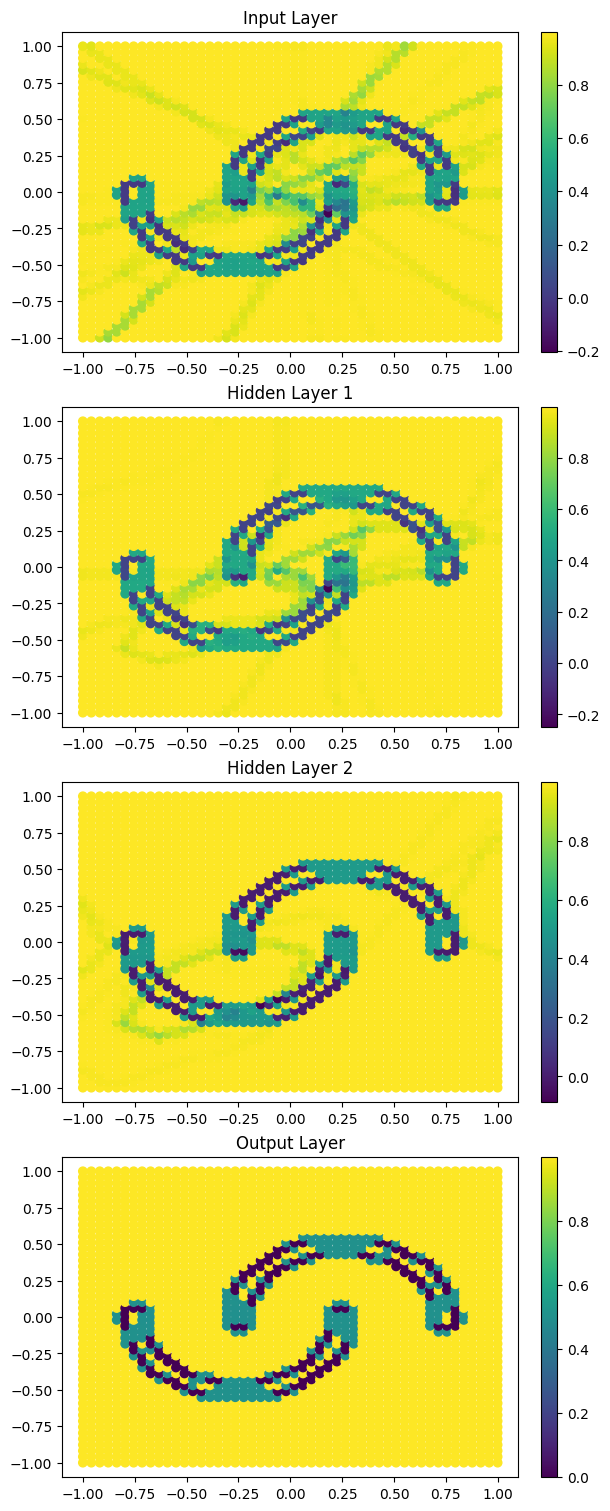

In [70]:
fig, axs = plt.subplots(4,1,figsize=(6,15),layout='constrained')

pcm0 = axs[0].scatter(X[:,0], X[:,1],c=dot_matrix_input_layer)
axs[0].set_title('Input Layer')

fig.colorbar(pcm0, ax=axs[0])

pcm1 = axs[1].scatter(X[:,0], X[:,1],c=dot_matrix_hidden_one)
axs[1].set_title('Hidden Layer 1')

fig.colorbar(pcm1, ax=axs[1])

pcm2 = axs[2].scatter(X[:,0], X[:,1],c=dot_matrix_hidden_two)
axs[2].set_title('Hidden Layer 2')

fig.colorbar(pcm2, ax=axs[2])

pcm3 = axs[3].scatter(X[:,0], X[:,1],c=dot_matrix_output_layer)
axs[3].set_title('Output Layer')

fig.colorbar(pcm3, ax=axs[3])